#Image Captioning: GRU Decoder
Simran Nayyar, Dina Dehaini, David Wang, Aditi Krishnakumar

LIGN 167

### References:
* https://www.tensorflow.org/tutorials/text/image_captioning
* https://cs.stanford.edu/people/karpathy/cvpr2015.pdf
* https://www.analyticsvidhya.com/blog/2018/04/solving-an-image-captioning-task-using-deep-learning/
* Dataset: http://cocodataset.org/#home


In [ ]:
# import relevant packages
import tensorflow as tf
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
from tqdm import tqdm
import pickle

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

## Downloading the Dataset
Each image has around 5 reference captions each.

In [ ]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510582272/13510573713 [==============================] - 806s 0us/step


## Limit the size of the training set 
Using a subset of 10,000 images (50,000 captions approximately)

In [ ]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [ ]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [ ]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)
train_image_paths = image_paths[:10000]
print(len(train_image_paths))

10000


In [ ]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> an orange cat is lying on a white blanket <end>


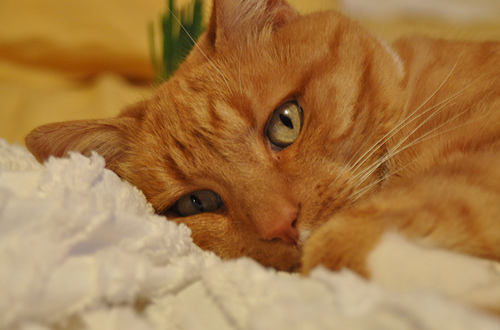

In [ ]:
# Example
print(train_captions[5])
Image.open(img_name_vector[5])

## Pretrained model: InceptionV3
Resizing and Normalizing the images

In [ ]:
# resizing image to 299x299pixels
# normalize pixels ([-1,-1])
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Load pre-trained ImageNet weights
The output layer of image_features_extract_model is the last convolutional layer in Pre-trained model. 

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 1s 0us/step


## Caching the features extracted from InceptionV3
Cache output to disk after processing images through pre-trained model. 

In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 625/625 [02:40<00:00,  3.90it/s]


In [ ]:
print(path_of_feature)

train2014/COCO_train2014_000000581921.jpg


## Preprocess and tokenize the captions

Transform the text captions into integer sequences using the TextVectorization layer, with the following steps:

* Use adapt to iterate over all captions, split the captions into words, and compute a vocabulary of the top 5,000 words.
* Tokenize all captions by mapping each word to it's index in the vocabulary. All output sequences will be padded to length 50.
* Create word-to-index and index-to-word mappings to display results.

In [ ]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 50
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [ ]:
# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [ ]:
# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

## Split the data into Training and Testing

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])  # number of ref captions per image
  img_name_train.extend([imgt] * capt_len) # image files * number of ref captions
  cap_train.extend(img_to_cap_vector[imgt]) # captions as vector

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv]) # number of ref captions per image
  img_name_val.extend([imgv] * capv_len) # image files * number of ref captions
  cap_val.extend(img_to_cap_vector[imgv]) # captions as vector

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(40020, 40020, 10001, 10001)

In [ ]:
# save larger variables so easy to reload next time
with open("img_name_train", "wb") as fp:   #Pickling
  pickle.dump(img_name_train, fp)
with open("img_name_val", "wb") as fp:   #Pickling
  pickle.dump(img_name_val, fp)
with open("cap_train", "wb") as fp:   #Pickling
  pickle.dump(cap_train, fp)
with open("cap_val", "wb") as fp:   #Pickling
  pickle.dump(cap_val, fp)

## Create a tf.data dataset for training and testing


In [ ]:
# Uncomment if want to re-load variables

# with open("img_name_train", "rb") as fp:   # Unpickling
#   img_name_train = pickle.load(fp)
# with open("img_name_val", "rb") as fp:   # Unpickling
#   img_name_val = pickle.load(fp)
# with open("cap_train", "rb") as fp:   # Unpickling
#   cap_train = pickle.load(fp)
# with open("cap_val", "rb") as fp:   # Unpickling
#   cap_val = pickle.load(fp)
# #with open("img_to_cap_vector", "rb") as fp:   # Unpickling
#   #img_to_cap_vector = pickle.load(fp)

In [ ]:
# Parameters
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
valdataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))
 
# Use map to load the numpy files in parallel
valdataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)
 
# Shuffle and batch
valdataset = valdataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
valdataset = valdataset.prefetch(buffer_size=tf.data.AUTOTUNE)


## Model
* Extract the features from the lower convolutional layer of InceptionV3.
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

## Optimizer and Loss Function

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint
Save model at checkpoints

In [ ]:
checkpoint_path = "./checkpoints_new/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
ckpt.restore(ckpt_manager.latest_checkpoint)

## Training


In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  
  hidden = decoder.reset_state(batch_size=target.shape[0])

  # start token
  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
@tf.function
def evaluate_step(img_tensor_val, target):
    loss = 0
 
    hidden = decoder.reset_state(batch_size=target.shape[0])
    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)
 
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)
        loss += loss_function(target[:, i], predictions)
       
    total_loss = (loss / int(target.shape[1]))
    return loss, total_loss


In [ ]:
EPOCHS = 20
val_losses = []
loss_plot = []
start = 0
end = 50
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    vtotal_loss = 0
 
    for (batch, (img_tensor, target)) in enumerate(valdataset[start:end]):  #valdataset[start:end] //increase start and end by 1/n each epoch
            vbatch_loss, vt_loss = evaluate_step(img_tensor, target)
            vtotal_loss += vt_loss
 
            if batch % 100 == 0:
                average_batch_loss = batch_loss.numpy()/int(target.shape[1])
 
    val_losses.append(vtotal_loss / num_steps)
 
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
 
        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
 
    
  start += 50
  end += 50
 
    if epoch % 5 == 0:
      ckpt_manager.save()
 
    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')


Epoch 1 Batch 0 Loss 1.8590
Epoch 1 Batch 100 Loss 1.0706
Epoch 1 Batch 200 Loss 0.9369
Epoch 1 Batch 300 Loss 0.8490
Epoch 1 Batch 400 Loss 0.8343
Epoch 1 Batch 500 Loss 0.7860
Epoch 1 Batch 600 Loss 0.8056
Epoch 1 Loss 0.933633
Time taken for 1 epoch 438.82 sec

Epoch 2 Batch 0 Loss 0.8355
Epoch 2 Batch 100 Loss 0.7558
Epoch 2 Batch 200 Loss 0.7384
Epoch 2 Batch 300 Loss 0.7614
Epoch 2 Batch 400 Loss 0.7337
Epoch 2 Batch 500 Loss 0.7126
Epoch 2 Batch 600 Loss 0.7205
Epoch 2 Loss 0.724261
Time taken for 1 epoch 293.16 sec

Epoch 3 Batch 0 Loss 0.6776
Epoch 3 Batch 100 Loss 0.7044
Epoch 3 Batch 200 Loss 0.7256
Epoch 3 Batch 300 Loss 0.6468
Epoch 3 Batch 400 Loss 0.6145
Epoch 3 Batch 500 Loss 0.6491
Epoch 3 Batch 600 Loss 0.6386
Epoch 3 Loss 0.662171
Time taken for 1 epoch 291.46 sec

Epoch 4 Batch 0 Loss 0.6627
Epoch 4 Batch 100 Loss 0.6124
Epoch 4 Batch 200 Loss 0.6312
Epoch 4 Batch 300 Loss 0.6516
Epoch 4 Batch 400 Loss 0.6545
Epoch 4 Batch 500 Loss 0.5638
Epoch 4 Batch 600 Loss 0.62

In [ ]:
# save models
encoder.save('saved_model/encoder')
decoder.save('saved_model/decoder')

INFO:tensorflow:Assets written to: saved_model/encoder/assets


INFO:tensorflow:Assets written to: saved_model/decoder/assets


INFO:tensorflow:Assets written to: saved_model/decoder/assets


## Loss Plot

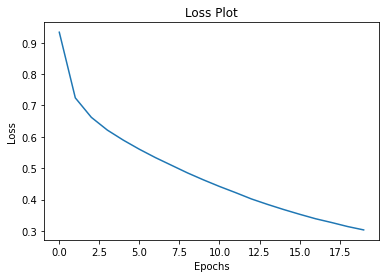

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Testing

* The evaluate function does not use the teacher forcing method. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* Store the attention weights for every time step.

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    # comment below if reloading model
    hidden = decoder.reset_state(batch_size=1)

    #hidden = tf.zeros((1, units))

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        # stop predicting if reach end token
        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

## Testing

Real Caption: <start> there is a boy eating a red shirt playing tennis <end>
Prediction Caption: a tennis is walking onto a tennis court playing tennis. <end>


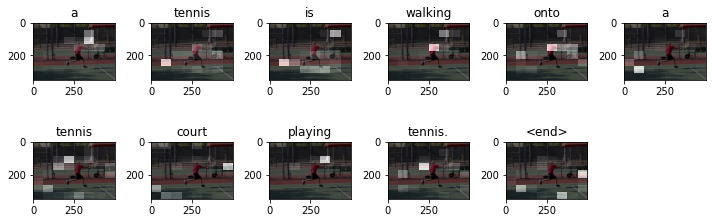

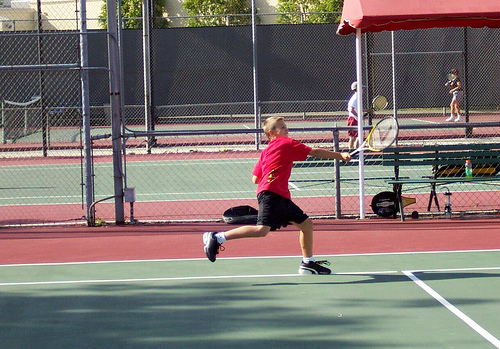

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val)) #index
image = img_name_val[rid] # image 
# convert vector to sentence
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])

# prediction
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))

# attention plot
plot_attention(image, result, attention_plot)
Image.open(image)

## BLEU Score

In [ ]:
# smoothening function
smoothie = SmoothingFunction().method4

In [ ]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [ ]:
# checking BLEU function
ref  = ["this is an image of three sheep in a field".split(' ')]
pred = "two sheep and a baby sheep standing on lush green field".split(' ')
score1 = sentence_bleu(ref, pred, weights=(1, 0, 0, 0))
score4 = sentence_bleu(ref, pred, weights=(0.25, 0.25, 0.25, 0.25)) # default

print(score1,score4)

0.2727272727272727 0.7226568811456053


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


### Evaluating on Validation set

Attempt to improve BLEU by having multiple captions as references per image. GPU constraints did not allow this

In [ ]:
# attempt to have multiple captions as references per image
img_to_captions = {}
i = 0
for img in img_name_val:
  cvecs = img_to_cap_vector[img]
  captions = []
  for cvector in cvecs:
    sentence = []
    for word in cvector:
      if word not in [0,3,4]: # remove '','<start>','<end>'
        sentence.append(tf.compat.as_text(index_to_word(word).numpy()))
    captions.append(sentence)
  img_to_captions[img] = captions
  i+=1
  print(i,end=" ")

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

In [ ]:
# NEW BLEU: GPU constraints did not allow this
i = 0
bleu_4_new = []
bleu_1_new = []
while i < len(img_name_val):
  image = img_name_val[i][9:] # get rid of "/content/"
  cap_len = len(img_to_cap_vector[img_name_val[i]])
  ref = img_to_captions[image]
  for caption in ref:
    if '<start>' in caption:
      caption.remove('<start>')
    if '<end>' in caption:
      caption.remove('<end>')
  pred, attention_plot = evaluate(img_name_val[i])
  if '<start>' in pred:
    pred.remove('<start>')
  if '<end>' in pred:
    pred.remove('<end>')
  score1 = sentence_bleu(ref, pred, weights=(1, 0, 0, 0))
  score4 = sentence_bleu(ref, pred, weights=(0.25, 0.25, 0.25, 0.25))
  bleu_1_new.append(score1)
  bleu_4_new.append(score4)
  print(i)
  i += cap_len

Calculate BLEU scores with single caption as reference per image

In [ ]:
# OLD BLEU WITH 1 REF
i = 0
bleu_1 = [] # weights = 1,0,0,0
bleu_4 = [] # weights = 0.25, 0.25, 0.25, 0.25

# iterate through validation set
while i < len(img_name_val):
  image = img_name_val[i]
  cap_len = len(img_to_cap_vector[img_name_val[i]])

  # convert reference vector to sentence
  ref = [tf.compat.as_text(index_to_word(word).numpy())
                         for word in cap_val[i] if word not in [0]]
  # remove start and end tokens before calculating BLEU scores                
  if '<start>' in ref:
    ref.remove('<start>')
  if '<end>' in ref:
    ref.remove('<end>')
  ref = [ref]

  # predicted sentence
  pred, attention_plot = evaluate(image)
  if '<start>' in pred:
    pred.remove('<start>')
  if '<end>' in pred:
    pred.remove('<end>')
  
  score1 = sentence_bleu(ref, pred, weights=(1, 0, 0, 0))
  score4 = sentence_bleu(ref, pred, weights=(0.25, 0.25, 0.25, 0.25))
  bleu_1.append(score1)
  bleu_4.append(score4)
  print(i)
  i += cap_len

0


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


5


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


10
15
20
25


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


30
35
40
45
50
55
60
65
70
76
81
86
91
96
101
106
111
116
121
126
131
136
141
146
151
156
161
166
171
176
181
186
191
196
201
206
211
216
221
226
231
236
241
246
251
256
261
266
271
276
281
286
291
296
301
306
311
316
321
326
331
336
341
346
351
356
361
366
371
376
381
386
391
396
401
406
411
416
421
426
431
436
441
446
451
456
461
466
471
476
481
486
491
496
501
506
511
516
521
526
531
536
541
546
551
556
561
566
571
576
581
586
591
596
601
606
611
616
621
626
631
636
641
646
651
656
661
666
671
676
681
686
691
696
701
706
711
716
721
726
731
736
741
746
751
756
761
766
771
776
781
786
791
796
801
806
811
816
821
826
831
836
841
846
851
856
861
866
871
876
881
886
891
896
901
906
911
916
921
926
931
936
941
946
951
956
961
966
971
976
981
986
991
996
1001
1006
1011
1016
1021
1026
1031
1036
1041
1046
1051
1056
1061
1066
1071
1076
1081
1086
1091
1096
1101
1106
1111
1116
1121
1126
1131
1136
1141
1146
1151
1156
1161
1166
1171
1176
1181
1186
1191
1196
1201
1206
1211
1216
1221
1226
1231
123

In [ ]:
# save BLEU scores
with open("bleu_1", "wb") as fp:   #Pickling
  pickle.dump(bleu_1, fp)
with open("bleu_4", "wb") as fp:   #Pickling
  pickle.dump(bleu_4, fp)

In [ ]:
# calculate average scores
avg_bleu_1 = sum(bleu_1)/len(bleu_1)
avg_bleu = sum(bleu_4)/len(bleu_4)

Average BLEU Score

In [ ]:
print("Average BLEU Score", avg_bleu)
print("Average BLEU_1 Score", avg_bleu_1)

Average BLEU Score 0.46252628015674196
Average BLEU_1 Score 0.22160951853919814


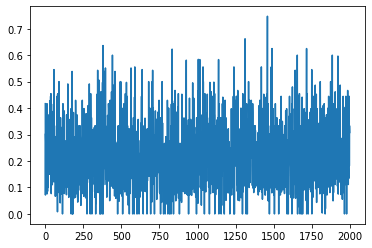

In [ ]:
plt.plot(bleu_1)

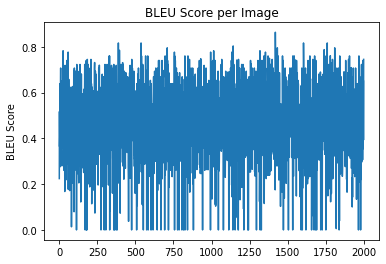

In [ ]:
plt.plot(bleu_4)
plt.title("BLEU Score per Image")
plt.ylabel("BLEU Score")
plt.show()

## Thank you!